In [1]:
import itertools
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
ALPHA = 0.05
L = 5
NUM_SIMULATIONS = 20000

In [3]:
ms = [4, 8, 16, 32, 64]
true_null_pcts = [0.75, 0.5, 0.25, 0]
alt_distrs = ['D', 'E', 'I']

alt_group_proportion_dict = {
    # linearly decreasing number of hypotheses away from 0
    'D': [0.4, 0.3, 0.2, 0.1],
    # equal number of hypotheses in each group
    'E': [0.25, 0.25, 0.25, 0.25],
    # linearly increasing number of hypotheses away from 0
    'I': [0.1, 0.2, 0.3, 0.4],
}

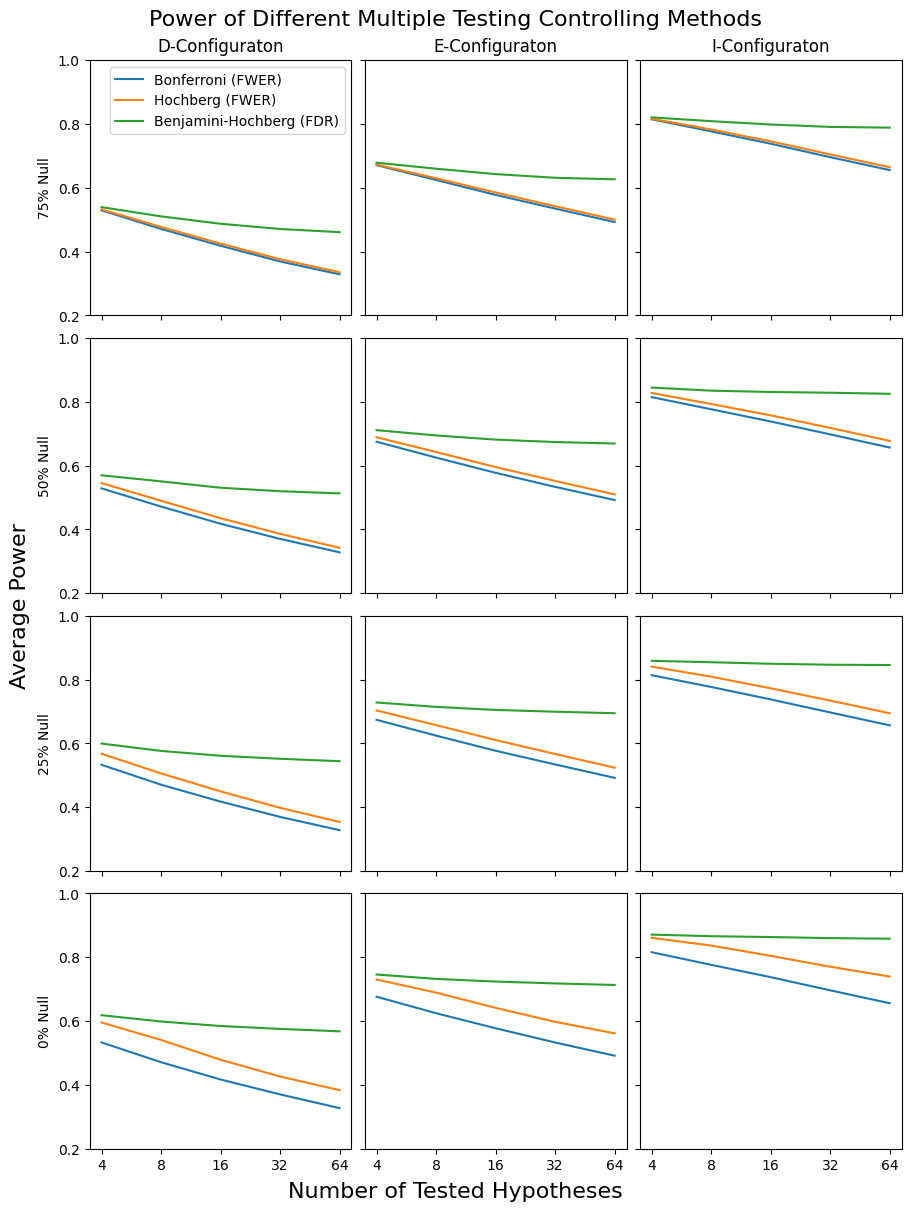

In [4]:
fig, axs = plt.subplots(4, 3, figsize=(9, 12), constrained_layout=True)

# iterate through different combinations of true null proportion and alternative hypothesis distribution
for (true_null_pct, alt_distr), ax in zip(itertools.product(true_null_pcts, alt_distrs), axs.ravel()):

    alt_group_proportion = alt_group_proportion_dict[alt_distr]

    # record averge power under each m
    bonferroni_power_avgs = []
    hochberg_power_avgs = []
    benjamini_power_avgs = []
    
    for m in ms:

        total_alt_hypothesis = int(NUM_SIMULATIONS * m * (1 - true_null_pct))

        # generate alternative hypotheses for imulation trials
        # note that the alternative hypotheses for all trials are generated once: this allow us to test different configuration (D, E, I) for small m (e.g. m=4)
        alt_hypotheses = np.concatenate([
            np.random.normal(
                L / 4, 1, int(total_alt_hypothesis * alt_group_proportion[0])),
            np.random.normal(
                L / 2, 1, int(total_alt_hypothesis * alt_group_proportion[1])),
            np.random.normal(
                L * 3 / 4, 1, int(total_alt_hypothesis * alt_group_proportion[2])),
            np.random.normal(
                L, 1, int(total_alt_hypothesis * alt_group_proportion[3]))
        ]).reshape(NUM_SIMULATIONS, -1)
        np.random.shuffle(alt_hypotheses)
        
        # record the power of each trial
        bonferroni_powers = []
        hochberg_powers = []
        benjamini_powers = []

        for i in range(NUM_SIMULATIONS):

            true_null = int(m * true_null_pct)

            # generate z-scores
            z_scores = np.concatenate([
                np.random.normal(0, 1, true_null),
                alt_hypotheses[i, :]
            ])

            # assume two-tailed test
            p_values = stats.norm.sf(np.abs(z_scores))

            # bonferroni correction
            bonferroni_reject = np.where(p_values <= ALPHA / m)[0]
            bonferroni_power = np.sum(bonferroni_reject >= int(true_null)) / (m - int(true_null))

            # hochberg method
            sort_idx = np.argsort(p_values)
            constraint_satisfy = np.where(p_values[sort_idx] <= ALPHA / (m + 1 - np.arange(1, m + 1)))[0]
            reject_until = constraint_satisfy[-1] if len(constraint_satisfy) > 0 else -1
            hochberg_reject = sort_idx[:reject_until + 1]
            hochberg_power = np.sum(hochberg_reject >= int(
                true_null)) / (m - int(true_null))

            # benjamini-hochberg method
            constraint_satisfy = np.where(
                p_values[sort_idx] <= ALPHA * (np.arange(1, m + 1)) / m)[0]
            reject_until = constraint_satisfy[-1] if len(constraint_satisfy) > 0 else -1
            benjamini_reject = sort_idx[:reject_until + 1]
            benjamini_power = np.sum(benjamini_reject >= int(
                true_null)) / (m - int(true_null))

            # record power of each trial
            bonferroni_powers.append(bonferroni_power)
            hochberg_powers.append(hochberg_power)
            benjamini_powers.append(benjamini_power)
        
        # record average power under each m
        bonferroni_power_avgs.append(np.mean(bonferroni_powers))
        hochberg_power_avgs.append(np.mean(hochberg_powers))
        benjamini_power_avgs.append(np.mean(benjamini_powers))

    # plot power under each m
    ax.plot(bonferroni_power_avgs)
    ax.plot(hochberg_power_avgs)
    ax.plot(benjamini_power_avgs)
    ax.set_xticks([0, 1, 2, 3, 4], ms)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

    if true_null_pct == 0.75:
        ax.set_title(f'{alt_distr}-Configuraton')
        if alt_distr == 'D':
            ax.legend(['Bonferroni (FWER)', 'Hochberg (FWER)', 'Benjamini-Hochberg (FDR)'])
    
    if alt_distr == 'D':
        ax.set_ylabel(f'{int(true_null_pct * 100)}% Null')
    else:
        ax.set_yticklabels([])
    
    if true_null_pct != 0:
        ax.set_xticklabels([])


fig.supylabel("Average Power", fontsize=16)
fig.supxlabel("Number of Tested Hypotheses", fontsize=16)
plt.suptitle("Power of Different Multiple Testing Controlling Methods", fontsize=16)
plt.show()
